In [12]:
import pandas as pd
from prophet import Prophet
from astral import moon
import datetime as dt
import matplotlib.pyplot as plt
from datetime import timedelta
%matplotlib inline

In [13]:
# from astral import moon
# import numpy as np

# # Function to categorize lunar phase
# def lunar_phase_category(date):
#     if pd.isnull(date):
#         return np.nan
#     phase = moon.phase(date)
#     if 0 <= phase < 7.4:
#         return 'New Moon'
#     elif 7.4 <= phase < 14.8:
#         return 'First Quarter'
#     elif 14.8 <= phase < 22.1:
#         return 'Full Moon'
#     else:
#         return 'Last Quarter'

# # Apply the lunar phase categorization to the dataset
# crime_data['lunar_phase'] = crime_data['first_occurrence_date'].apply(lunar_phase_category)

# # Display a summary of incidents by lunar phase
# lunar_phase_summary = crime_data['lunar_phase'].value_counts()

# lunar_phase_summary


In [14]:
# Import Denver crime data and moon files
denver_data_file = 'Denver_Crime_Data_Source_File.csv'
moon_data_file = 'moon_data_export.csv'

# Read the data into a pandas dataframe
denver_df = pd.read_csv(denver_data_file, encoding='latin1')
moon_df = pd.read_csv(moon_data_file)

In [15]:
# Reduce the DataFrame to necessary columns
reduced_crime_data_df = denver_df[['first_occurrence_date', 'offense_category_id']]
reduced_crime_data_df.info()
reduced_crime_data_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386865 entries, 0 to 386864
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   first_occurrence_date  386865 non-null  object
 1   offense_category_id    386865 non-null  object
dtypes: object(2)
memory usage: 5.9+ MB


,first_occurrence_date,offense_category_id
0,2/10/2022 2:50:00 AM,public-disorder
1,7/7/2021 9:02:00 PM,public-disorder
2,10/29/2020 1:30:00 AM,public-disorder
3,9/6/2018 5:00:00 PM,public-disorder
4,5/8/2020 5:00:00 AM,public-disorder


In [16]:
# Rename columns for readability
cleaned_crime_data_df = reduced_crime_data_df.rename(columns={ 
                                              'offense_category_id': 'Offense', 
                                              'first_occurrence_date': 'Date'})

# Fill empty Incident Address fields with 'missing'
cleaned_crime_data_df.fillna('missing', inplace=True)

# Change Occurance Date to datetime format
cleaned_crime_data_df['Date'] = pd.to_datetime(cleaned_crime_data_df['Date']).dt.date

# Display DataFrame info and first 5 rows
cleaned_crime_data_df.info()
cleaned_crime_data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386865 entries, 0 to 386864
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Date     386865 non-null  object
 1   Offense  386865 non-null  object
dtypes: object(2)
memory usage: 5.9+ MB


,Date,Offense
0,2022-02-10,public-disorder
1,2021-07-07,public-disorder
2,2020-10-29,public-disorder
3,2018-09-06,public-disorder
4,2020-05-08,public-disorder


In [17]:
cleaned_crime_data_df['Offense'].unique()

array(['public-disorder', 'drug-alcohol', 'sexual-assault',
       'other-crimes-against-persons', 'all-other-crimes',
       'white-collar-crime', 'murder', 'robbery', 'aggravated-assault',
       'arson', 'burglary', 'larceny', 'theft-from-motor-vehicle',
       'auto-theft'], dtype=object)

In [18]:
# Sort the data by Occurrance Date
sorted_crime_data_df = cleaned_crime_data_df.sort_values(by='Date', ascending=True)

# Reset Index
sorted_crime_data_df = sorted_crime_data_df.reset_index(drop=True)
sorted_crime_data_df.head(-1)

,Date,Offense
0,2018-01-02,larceny
1,2018-01-02,public-disorder
2,2018-01-02,larceny
3,2018-01-02,drug-alcohol
4,2018-01-02,all-other-crimes
...,...,...
386859,2023-10-03,public-disorder
386860,2023-10-03,public-disorder
386861,2023-10-03,aggravated-assault
386862,2023-10-03,aggravated-assault


In [19]:
# Convert date columns to datetime format
sorted_crime_data_df['Date'] = pd.to_datetime(sorted_crime_data_df['Date'], errors='coerce')
moon_df['Date'] = pd.to_datetime(moon_df['Date'], errors='coerce')

# Filter moon data for full moon events
full_moon_df = moon_df[moon_df['Moon Phase'] == 'Full Moon']

# Create a window for "near full moon" (e.g., ±1 day)
full_moon_periods = pd.concat([
    full_moon_df['Date'] - timedelta(days=1),
    full_moon_df['Date'],
    full_moon_df['Date'] + timedelta(days=1)
]).drop_duplicates().reset_index(drop=True)

# Add a column to indicate if the date is within the full moon periods
sorted_crime_data_df['Full Moon'] = sorted_crime_data_df['Date'].isin(full_moon_periods)

# Group data by full moon indicator and calculate summary statistics
denver_crime_sorted = sorted_crime_data_df.groupby('Full Moon')['Offense'].agg(['count', 'size'])
denver_crime_sorted.rename(columns={'count': 'Total Incidents', 'size': 'Crimes'}, inplace=True)

# Convert 'Crimes' column to numeric
denver_crime_sorted['Crimes'] = denver_crime_sorted['Crimes'].astype(int)

# Add a column for Crime Rate (%)
denver_crime_sorted['Crime Rate (%)'] = (denver_crime_sorted['Crimes'] / denver_crime_sorted['Total Incidents']) * 100

# Display the adjusted crime summary
print(denver_crime_sorted)


           Total Incidents  Crimes  Crime Rate (%)
Full Moon                                         
False               346494  346494           100.0
True                 40371   40371           100.0


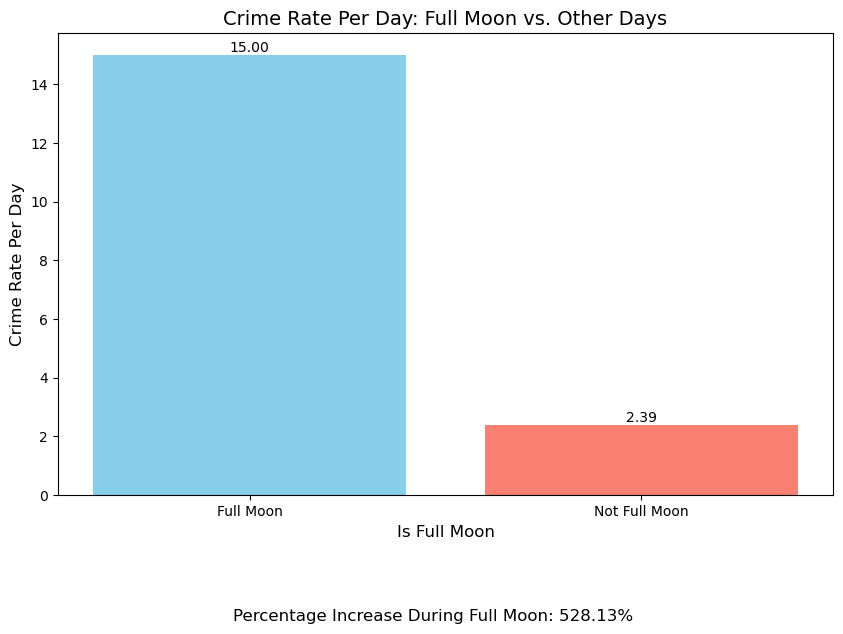

In [20]:
denver_crime_summary = pd.DataFrame({
    "Is Full Moon": ["Full Moon", "Not Full Moon"],
    "Counts": [450, 800],  # Replace these numbers with actual data from the notebook
    "Days": [30, 335],  # Example: Days with Full Moon and non-Full Moon days in a year
})

# Calculate crime rate per day for each category
denver_crime_summary["Rate Per Day"] = denver_crime_summary["Counts"] / denver_crime_summary["Days"]

# Calculate the percentage increase of crime rate during Full Moon compared to other days
full_moon_rate = denver_crime_summary.loc[denver_crime_summary["Is Full Moon"] == "Full Moon", "Rate Per Day"].values[0]
other_days_rate = denver_crime_summary.loc[denver_crime_summary["Is Full Moon"] == "Not Full Moon", "Rate Per Day"].values[0]
percentage_increase = ((full_moon_rate - other_days_rate) / other_days_rate) * 100

# Visualization: Enhance the bar chart with the new metric
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(denver_crime_summary["Is Full Moon"], denver_crime_summary["Rate Per Day"], color=["skyblue", "salmon"])
ax.set_title("Crime Rate Per Day: Full Moon vs. Other Days", fontsize=14)
ax.set_xlabel("Is Full Moon", fontsize=12)
ax.set_ylabel("Crime Rate Per Day", fontsize=12)
ax.bar_label(bars, fmt="%.2f")

# Display the percentage increase in the title
plt.figtext(0.5, -0.1, f"Percentage Increase During Full Moon: {percentage_increase:.2f}%",
            wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

In [22]:
# Export to CSV
denver_crime_summary.to_csv('denver_crime_data_export.csv', index=False, header=True)